In [115]:
import pandas as pd
from pathlib import Path
import json

results_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/results/gpt2_simulation/all_at_once"
results = dict()
for fname in Path(results_dir).iterdir():
    with open(fname, "r") as f:
        r = json.load(f)
    last = fname.stem.split(".")[-1]
    layer = int(last.split("_")[0])
    feat = int(last[last.index("_feature") + len("_feature"):])
    results[fname.stem] = {"ev_correlation_score": r["ev_correlation_score"], "layer": layer, "feature": feat}
results = pd.DataFrame(results).T
results["layer"] = results["layer"].astype(int)
results["feature"] = results["feature"].astype(int)
results = results.sort_values("ev_correlation_score", ascending=False)
unq_layers = results["layer"].unique()
results

,ev_correlation_score,layer,feature
.transformer.h.2_feature0,0.970093,2,0
.transformer.h.2_feature19,0.966378,2,19
.transformer.h.0_feature0,0.952401,0,0
.transformer.h.4_feature4,0.952061,4,4
.transformer.h.0_feature5,0.949993,0,5
.transformer.h.2_feature4,0.941871,2,4
.transformer.h.2_feature11,0.930066,2,11
.transformer.h.4_feature19,0.918787,4,19
.transformer.h.0_feature14,0.906342,0,14
.transformer.h.0_feature3,0.897080,0,3


In [181]:
import torch


def cosine_sim(a, b):
    a = a.squeeze()
    b = b.squeeze()
    return a @ b / (a.norm() * b.norm())


def homogeneity(embeddings, weights=None):
    if weights is not None:
        weights = len(weights) * weights.reshape(-1, 1) / weights.sum()
        embeddings = embeddings * weights  # [B, D] x [B, 1] -> [B, D]
    return 1 / torch.cdist(embeddings, embeddings, p=2).mean()
    # embeddings = embeddings / embeddings.norm(dim=-1, keepdim=True)
    # return (embeddings @ embeddings.mT).mean()

In [182]:
top_logits

torch.return_types.topk(
values=tensor([0.6752, 0.6462, 0.6359, 0.6248, 0.6223, 0.6042, 0.5996, 0.5993, 0.5961,
        0.5881], device='cuda:0'),
indices=tensor([30018, 38627, 17325, 47264,  5533, 44008, 41933, 44097, 26723, 35247],
       device='cuda:0'))

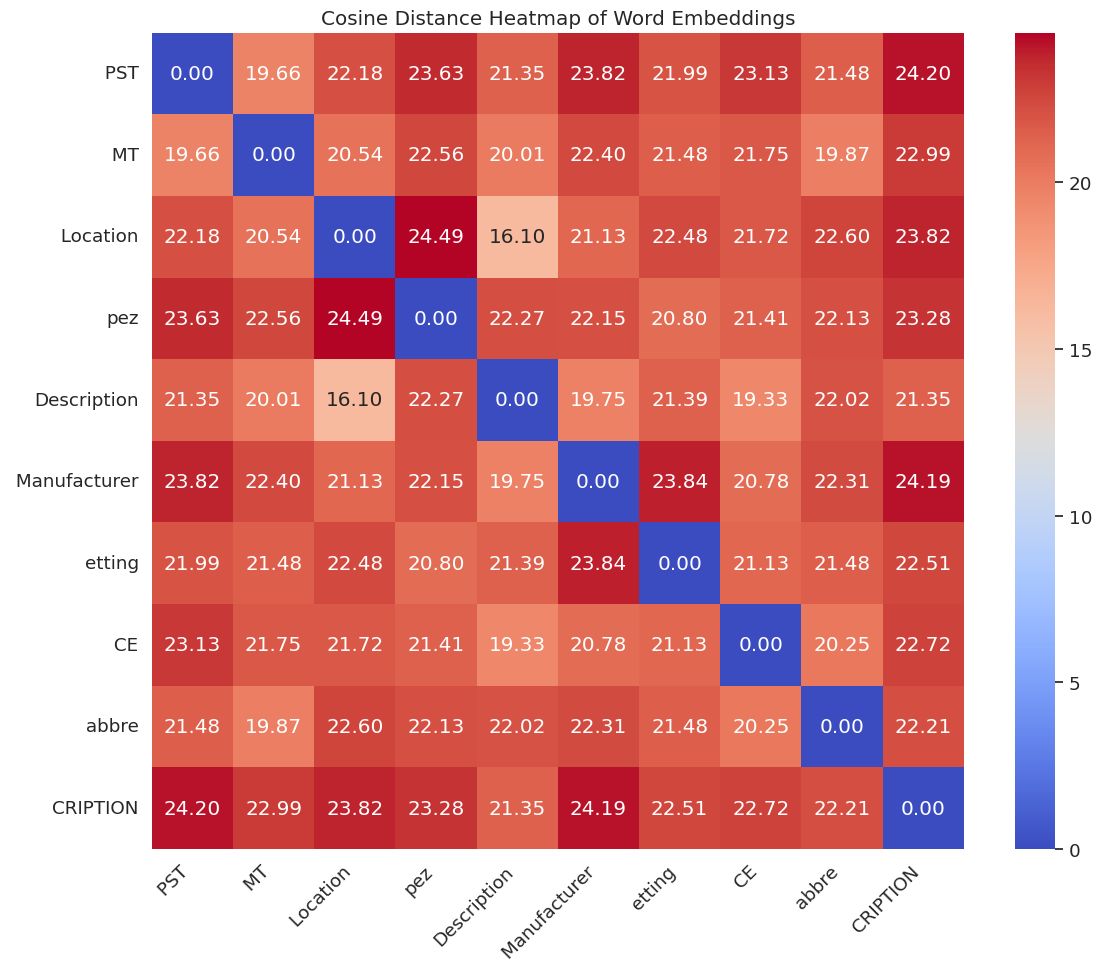

In [227]:
words = [' PST', ' MT', ' Location', 'pez', 'Description', ' Manufacturer', 'etting', ' CE', ' abbre', 'CRIPTION']
torch.cdist(top_embeddings, top_embeddings, p=2)
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap of the cosine similarity matrix
similarity_matrix = torch.cdist(top_embeddings, top_embeddings, p=2).cpu().numpy()

# Set up the plot
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.2)

# Create the heatmap
heatmap = sns.heatmap(similarity_matrix, 
                      annot=True, 
                      cmap='coolwarm', 
                      xticklabels=words, 
                      yticklabels=words, 
                      fmt='.2f')

# Set the title
plt.title('Cosine Distance Heatmap of Word Embeddings')

# Rotate the tick labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


In [173]:
from nnsight import LanguageModel

# Load the GPT-2 model
model = LanguageModel('openai-community/gpt2', device_map='cuda')
# do some inference to load the weights. Annoying!
with model.generate('The Eiffel Tower is in the city of', max_new_tokens=3) as tracer:
    pass

Setting `pad_token_id` to `eos_token_id`:FakeTensor(..., device='meta', size=(), dtype=torch.int64) for open-end generation.
`eos_token_id` should consist of positive integers, but is FakeTensor(..., device='meta', size=(1,), dtype=torch.int64). Your generation will not stop until the maximum length is reached. Depending on other flags, it may even crash.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [207]:
import fasttext
import numpy as np

# Load pre-trained model
model = fasttext.load_model('wiki-news-300d-1M.vec')

def preprocess(text):
    # Convert to lowercase and strip whitespace
    return text.lower().strip()

def get_embedding(text):
    return model.get_word_vector(preprocess(text))

# Your list of words
words = ['Quran', 'Sharia', 'abad', 'holiest', 'Islamic', 'uddin', 'blasphemy', 'Koran', 'Islamic', 'Mecca']

# Get embeddings for each word
embeddings = [get_embedding(word) for word in words]

# Calculate cosine similarity between embeddings
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# Print similarity matrix
for i, word1 in enumerate(words):
    for j, word2 in enumerate(words):
        if i < j:  # Only print upper triangle of matrix
            similarity = cosine_similarity(embeddings[i], embeddings[j])
            print(f"Similarity between '{word1}' and '{word2}': {similarity:.4f}")

ValueError: wiki-news-300d-1M.vec has wrong file format!

In [213]:
from transformers import AutoModel, AutoTokenizer

encoder_name = "Alibaba-NLP/gte-large-en-v1.5"
encoder = AutoModel.from_pretrained(encoder_name).cuda()
encoder_tokenizer = AutoTokenizer.from_pretrained(encoder_name)

def embed(text):
    with torch.inference_mode():
        # x = model.tokenizer(text, return_tensors="pt").input_ids
        # embeddings = model.get_input_embeddings()        
        # return embeddings(x.to(embeddings.weight.device))
        x = encoder_tokenizer(text, return_tensors="pt").input_ids.cuda()
        return encoder(x).last_hidden_state.mean(dim=1).squeeze(0)

lm_head = model.lm_head

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [226]:
from sae_auto_interp.autoencoders import load_oai_autoencoders

k = 10
aes = load_oai_autoencoders(model, unq_layers.tolist(), "/mnt/ssd-1/gpaulo/SAE-Zoology/weights/gpt2_128k")

homogs = []
top_homogs = []
bottom_homogs = []
all_toks = []
for row in [results.loc[".transformer.h.2_feature0"]]:
    print(row["layer"], row["feature"])
    feat = aes[f".transformer.h.{int(row['layer'])}"].ae.ae.decoder.weight.data[:, int(row['feature'])]
    # feat = torch.randn_like(aes[f".transformer.h.{int(row['layer'])}"].ae.ae.decoder.weight.data[:, int(row['feature'])])

    # account for layernorm
    # for l in range(int(row['layer']) + 1, len(model.transformer.h)):
        # feat = model.transformer.h[l].ln_1.weight * feat
        # feat = model.transformer.h[l].ln_2.weight * feat

    logit_contributions = lm_head.weight.data @ feat
    top_logits = logit_contributions.topk(k)
    bottom_logits = logit_contributions.topk(k, largest=False)

    top_embeddings = torch.stack([embed(model.tokenizer.decode(id)) for id in top_logits.indices])
    bottom_embeddings = torch.stack([embed(model.tokenizer.decode(id)) for id in bottom_logits.indices])

    print("Top tokens:", [model.tokenizer.decode(tok) for tok in top_logits.indices])
    print("Bottom tokens:", [model.tokenizer.decode(tok) for tok in bottom_logits.indices])

    # top_h, bottom_h = homogeneity(top_embeddings).item(), homogeneity(bottom_embeddings).item()
    top_h, bottom_h = homogeneity(top_embeddings, weights=top_logits.values).item(), homogeneity(bottom_embeddings, weights=bottom_logits.values).item()
    # print(top_h, bottom_h, (lo, hi))
    homogs.append((top_h + bottom_h) / 2)
    top_homogs.append(top_h)
    bottom_homogs.append(bottom_h)
    all_toks.extend([model.tokenizer.decode(tok) for tok in top_logits.indices])
    all_toks.extend([model.tokenizer.decode(tok) for tok in bottom_logits.indices])
results["homogs"] = homogs
results["top_homogs"] = top_homogs
results["bottom_homogs"] = bottom_homogs

2.0 0.0
Top tokens: [' PST', ' MT', ' Location', 'pez', 'Description', ' Manufacturer', 'etting', ' CE', ' abbre', 'CRIPTION']
Bottom tokens: [' Happiness', ' grandchildren', 'justice', 'faith', ' prophets', 'alam', ' choir', 'Justice', ' justice', ' Journalists']


ValueError: Length of values (1) does not match length of index (43)

In [215]:
import random
from tqdm import tqdm

random_homogs = []
for _ in tqdm(range(100)):
    random_embeddings = torch.stack([embed(tok) for tok in random.sample(all_toks, k)])
    random_homogs.append(homogeneity(random_embeddings))
random_homos = torch.tensor(random_homogs)
lo, hi = random_homos.quantile(0.025).item(), random_homos.quantile(0.975).item()


100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


In [216]:
top_embeddings.shape, bottom_embeddings.shape

(torch.Size([10, 1024]), torch.Size([10, 1024]))

In [217]:

e = lambda x: model.tokenizer(x, return_tensors="pt").input_ids.cuda()[0]
toks = [' UTC', ' IST', ' GMT', 'UTC', ' Miko', 'ribune', ' EDT', ' Tah', 'INESS', 'hammad']
cosine_sim(embed(toks[0]), embed(toks[1])), homogeneity(torch.stack([embed(toks[i]) for i in range(2)]))

(tensor(0.6438, device='cuda:0'), tensor(0.0994, device='cuda:0'))

In [218]:
results

,ev_correlation_score,layer,feature,homogs,top_homogs,bottom_homogs
.transformer.h.2_feature0,0.970093,2,0,0.051933,0.050621,0.053244
.transformer.h.2_feature19,0.966378,2,19,0.049253,0.048990,0.049517
.transformer.h.0_feature0,0.952401,0,0,0.049756,0.049697,0.049814
.transformer.h.4_feature4,0.952061,4,4,0.051428,0.052045,0.050812
.transformer.h.0_feature5,0.949993,0,5,0.049912,0.048672,0.051152
.transformer.h.2_feature4,0.941871,2,4,0.053385,0.057175,0.049594
.transformer.h.2_feature11,0.930066,2,11,0.051609,0.053590,0.049629
.transformer.h.4_feature19,0.918787,4,19,0.049952,0.048339,0.051566
.transformer.h.0_feature14,0.906342,0,14,0.051772,0.051752,0.051792
.transformer.h.0_feature3,0.897080,0,3,0.049359,0.049707,0.049012


<Axes: xlabel='ev_correlation_score', ylabel='bottom_homogs'>

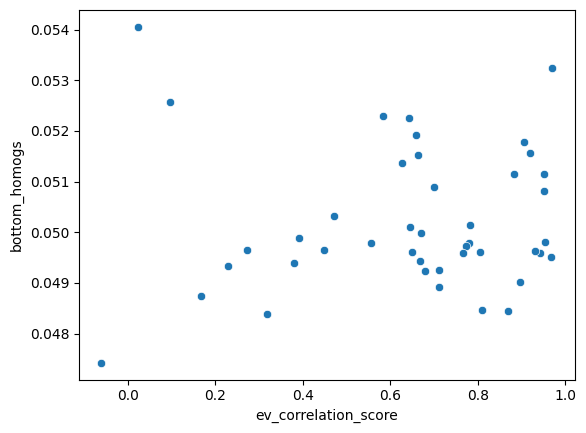

In [219]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.scatterplot(x=results["ev_correlation_score"], y=results["bottom_homogs"])

In [220]:
lo, hi

(0.04755272716283798, 0.052709002047777176)

In [199]:
import torch

toks = """
 1
1.12
 2
1.00
1
0.97
 3
0.95
 4
0.92
 8
0.91
 7
0.90
 6
0.89
 5
0.89
 9
""".split("\n")[1:-1:2]
print(toks)
encodings = tokenizer(toks, return_tensors="pt").input_ids
with torch.inference_mode():
    embeddings = embed(encodings).squeeze(1)
embeddings.shape

[' 1', ' 2', '1', ' 3', ' 4', ' 8', ' 7', ' 6', ' 5', ' 9']


NameError: name 'tokenizer' is not defined

(tensor(0.5440), tensor(0.2241))

In [124]:
layer = 10
fake_dictionary_weight = embed(tokenizer(" 1", return_tensors="pt").input_ids).squeeze() # torch.randn(768)

v = fake_dictionary_weight  # TODO account for layer norm
# for l in range(layer, len(model.transformer.h)):
#     v = model.transformer.h[l].ln_1(v)
#     v = model.transformer.h[l].ln_2(v)
    
assert model.lm_head.bias is None
logit_contributions = model.lm_head.weight.data @ v
topk = logit_contributions.topk(10)
topk, [tokenizer.decode(tok) for tok in topk.indices]

(torch.return_types.topk(
 values=tensor([6.7853, 5.5921, 5.1799, 5.1528, 4.8437, 4.7982, 4.6626, 4.4385, 4.3578,
         4.1862], grad_fn=<TopkBackward0>),
 indices=tensor([352, 362, 513,  16, 657, 604, 642, 718, 767, 807])),
 [' 1', ' 2', ' 3', '1', ' 0', ' 4', ' 5', ' 6', ' 7', ' 8'])

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   2.,
          1.,   1.,   0.,   0.,   2.,   0.,   1.,   2.,   1.,   5.,   3.,
         11.,  34.,  90., 170., 170., 127.,  87.,  25.,  13.,   5.,   4.,
          4.,   2.,   0.,   0.,   0.,   2.,   0.,   1.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-0.33035743, -0.31701479, -0.30367215, -0.29032951, -0.27698687,
        -0.26364422, -0.25030158, -0.23695894, -0.2236163 , -0.21027366,
        -0.19693102, -0.18358837, -0.17024573, -0.15690309, -0.14356045,
        -0.13021781, -0.11687517, -0.10353253, -0.09018988, -0.07684724,
        -0.0635046 , -0.05

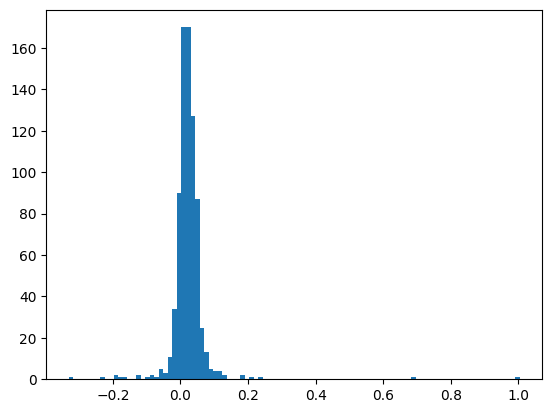

In [123]:
import matplotlib.pyplot as plt

plt.hist(model.transformer.h[l].ln_1.bias.data.tolist(), bins=100)

In [70]:
fake_dictionary_weight.shape

torch.Size([1, 1, 768])

# Output explanation scoring

In [96]:
from transformers import AutoModelForCausalLM, AutoTokenizer

scorer_name = "meta-llama/Meta-Llama-3-8B"
scorer = AutoModelForCausalLM.from_pretrained(scorer_name)
scorer_tokenizer = AutoTokenizer.from_pretrained(scorer_name)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [118]:
explanation = "I intervened on a feature that causes the model to use she/her pronouns more."
random_explanation = "I intervened on a feature that causes the model think of things related to mountains more."
null_explanation = "Here is a sentence."
example = "Sally went to the beach."

# scorer_tokenizer.apply_chat_template([{"role": "assistant", "content": f"Explanation:\n{explanation}\n\nExample:\n{example}"}], tokenize=False, add_generation_prompt=False)
def get_scorer_prompt(explanation):
    return f"Explanation:\n{explanation}\n\nExample:\n{example}"

def get_logprobs(text):
    with torch.inference_mode():
        logits = scorer(scorer_tokenizer(text, return_tensors="pt").input_ids).logits[0, -1, :]
    return logits.log_softmax(dim=-1)

top_diff_toks = [" She", " Her"]
top_logodds_diffs = torch.tensor([10.0, 8.0])
top_diff_ids = [scorer_tokenizer.encode(tok, add_special_tokens=False)[0] for tok in top_diff_toks]

def get_explanation_score(explanation):
    logprobs = get_logprobs(get_scorer_prompt(explanation))
    diff_distr = torch.sigmoid(top_logodds_diffs)
    print(diff_distr.sum())
    diff_distr /= diff_distr.sum()
    # get the scorer's logP(next_tok | explanation, prompt) averaged over 
    # the next_toks that were most affected by the intervention 
    # (weighted by the sigmoid(bayes factor) distribution)
    print(logprobs.shape, top_diff_ids)
    logposterior = diff_distr * logprobs[top_diff_ids]
    return logposterior.sum()

get_explanation_score(explanation), get_explanation_score(random_explanation), get_explanation_score(null_explanation)

tensor(1.9996)
torch.Size([128256]) [3005, 6385]
tensor(1.9996)
torch.Size([128256]) [3005, 6385]
tensor(1.9996)
torch.Size([128256]) [3005, 6385]


(tensor(-2.2770), tensor(-3.0543), tensor(-3.0925))